---
title: Space Shuttle Reentry Trajectory
---

**Originally Contributed by**: Henrique Ferrolho

This tutorial demonstrates how to compute a reentry trajectory for the
[Space Shuttle](https://en.wikipedia.org/wiki/Space_Shuttle),
by formulating and solving a nonlinear programming problem.
The problem was drawn from Chapter 6 of 
["Practical Methods for Optimal Control and Estimation Using Nonlinear Programming"](https://epubs.siam.org/doi/book/10.1137/1.9780898718577),
by John T. Betts.

The motion of the vehicle is defined by the following set of DAEs:

$$
\begin{align}
\dot{h} & = v \sin \gamma , \\
\dot{\phi} & = \frac{v}{r} \cos \gamma \sin \psi / \cos \theta , \\
\dot{\theta} & = \frac{v}{r} \cos \gamma \cos \psi , \\
\dot{v} & = -\frac{D}{m} - g \sin \gamma , \\
\dot{\gamma} & = \frac{L}{m v} \cos(\beta) + \cos \gamma \left ( \frac{v}{r} - \frac{g}{v} \right ) , \\
\dot{\psi} & = \frac{1}{m v \cos \gamma} L \sin(\beta) + \frac{v}{r \cos \theta} \cos \gamma \sin \psi \sin \theta , \\
q & \le q_U , \\
\end{align}
$$

where the aerodynamic heating on the vehicle wing leading edge is $q = q_a q_r$
and the dynamic variables are

$$
\begin{align}
     h & \quad \text{altitude (ft)},     \qquad & & \gamma \quad \text{flight path angle (rad)}, \\
  \phi & \quad \text{longitude (rad)},   \qquad & & \psi   \quad \text{azimuth (rad)},           \\
\theta & \quad \text{latitude (rad)},    \qquad & & \alpha \quad \text{angle of attack (rad)},   \\
     v & \quad \text{velocity (ft/sec)}, \qquad & & \beta  \quad \text{bank angle (rad)}.
\end{align}
$$

The aerodynamic and atmospheric forces on the vehicle are
specified by the following quantities (English units):

$$
\begin{align}
           D & = \frac{1}{2} c_D S \rho v^2,                  \qquad & a_0 & = -0.20704, \\
           L & = \frac{1}{2} c_L S \rho v^2,                  \qquad & a_1 & =  0.029244, \\
           g & = \mu / r^2,                                   \qquad & \mu & =  0.14076539 \times 10^{17}, \\
           r & = R_e + h,                                     \qquad & b_0 & =  0.07854, \\
        \rho & = \rho_0 \exp[-h/h_r],                         \qquad & b_1 & = -0.61592  \times 10^{-2}, \\
      \rho_0 & = 0.002378,                                    \qquad & b_2 & =  0.621408 \times 10^{-3}, \\
         h_r & = 23800,                                       \qquad & q_r & =  17700 \sqrt{\rho} (0.0001 v)^{3.07}, \\
         c_L & = a_0 + a_1 \hat{\alpha},                      \qquad & q_a & =  c_0 + c_1 \hat{\alpha} + c_2 \hat{\alpha}^2 + c_3 \hat{\alpha}^3, \\
         c_D & = b_0 + b_1 \hat{\alpha} + b_2 \hat{\alpha}^2, \qquad & c_0 & =  1.0672181, \\
\hat{\alpha} & = 180 \alpha / \pi,                            \qquad & c_1 & = -0.19213774 \times 10^{-1}, \\
         R_e & = 20902900,                                    \qquad & c_2 & =  0.21286289 \times 10^{-3}, \\
           S & = 2690,                                        \qquad & c_3 & = -0.10117249 \times 10^{-5}.
\end{align}
$$

The reentry trajectory begins at an altitude where the aerodynamic forces are quite small
with a weight of $w = 203000$ (lb) and mass $m = w / g_0$ (slug), where $g_0 = 32.174$ (ft/sec$^2$).
The initial conditions are as follows:

$$
\begin{align}
     h & = 260000 \text{ ft},  \qquad & v      & = 25600 \text{ ft/sec}, \\
  \phi & = 0      \text{ deg}, \qquad & \gamma & = -1    \text{ deg},    \\
\theta & = 0      \text{ deg}, \qquad & \psi   & = 90    \text{ deg}.
\end{align}
$$

The final point on the reentry trajectory occurs at the unknown (free) time $t_F$,
at the so-called terminal area energy management (TAEM) interface, which is defined by the conditions

$$
h = 80000 \text{ ft}, \qquad v = 2500 \text{ ft/sec}, \qquad \gamma = -5 \text{ deg}.
$$

As explained in the book, our goal is to maximize the final crossrange,
which is equivalent to maximizing the final latitude of the vehicle,
i.e., $J = \theta(t_F)$.

![Max crossrange shuttle reentry](https://i.imgur.com/1tUN3wM.png)

### Approach 
We will use a discretized model of time, with a fixed number of discretized points, $n$.
The decision variables at each point are going to be the state of the vehicle and the controls commanded to it.
In addition, we will also make each time step size $\Delta t$ a decision variable;
that way, we can either fix the time step size easily,
or allow the solver to fine-tune the duration between each adjacent pair of points.
Finally, in order to approximate the derivatives of the problem dynamics, we will use either rectangular
or [trapezoidal](http://en.wikipedia.org/wiki/Trapezoidal_rule) integration.

### Disclaimer
Do not try to actually land a Space Shuttle using this notebook! üòõ
There's no mesh refinement going on, which can lead to unrealistic trajectories having position
and velocity errors with orders of magnitude $10^4$ ft and $10^2$ ft/sec, respectively.

In [1]:
using Interpolations, Plots
using JuMP, Ipopt  # , KNITRO

In [2]:
# Global variables
const w  = 203000.0  # weight (lb)
const g‚ÇÄ = 32.174    # acceleration (ft/sec^2)
const m  = w / g‚ÇÄ    # mass (slug)

# Aerodynamic and atmospheric forces on the vehicle
const œÅ‚ÇÄ =  0.002378
const h·µ£ =  23800.0
const R‚Çë =  20902900.0
const Œº  =  0.14076539e17
const S  =  2690.0
const a‚ÇÄ = -0.20704
const a‚ÇÅ =  0.029244
const b‚ÇÄ =  0.07854
const b‚ÇÅ = -0.61592e-2
const b‚ÇÇ =  0.621408e-3
const c‚ÇÄ =  1.0672181
const c‚ÇÅ = -0.19213774e-1
const c‚ÇÇ =  0.21286289e-3
const c‚ÇÉ = -0.10117249e-5

# Initial conditions
const h‚Çõ = 2.6          # altitude (ft) / 1e5
const œï‚Çõ = deg2rad(0)   # longitude (rad)
const Œ∏‚Çõ = deg2rad(0)   # latitude (rad)
const v‚Çõ = 2.56         # velocity (ft/sec) / 1e4
const Œ≥‚Çõ = deg2rad(-1)  # flight path angle (rad)
const œà‚Çõ = deg2rad(90)  # azimuth (rad)
const Œ±‚Çõ = deg2rad(0)   # angle of attack (rad)
const Œ≤‚Çõ = deg2rad(0)   # banck angle (rad)
const t‚Çõ = 1.00         # time step (sec)

# Final conditions, the so-called Terminal Area Energy Management (TAEM)
const h‚Çú = 0.8          # altitude (ft) / 1e5
const v‚Çú = 0.25         # velocity (ft/sec) / 1e4
const Œ≥‚Çú = deg2rad(-5)  # flight path angle (rad)

# Number of mesh points (knots) to be used
const n = 2009

# Integration scheme to be used for the dynamics
const integration_rule = "rectangular"

"rectangular"

In [3]:
user_options_ipopt = (
    "mu_strategy" => "monotone",
    "linear_solver" => "ma27",  # For the best results, it is advised to experiment different linear solvers.
                                # If Ipopt is not compiled with MA27/MA57, it may fallback to 'MUMPS'.
                                # In general, the linear solver MA27 is much faster than MUMPS.
)

# user_options_knitro = (
#     "algorithm" => KNITRO.KN_ALG_BAR_DIRECT,
#     "bar_murule" => KNITRO.KN_BAR_MURULE_QUALITY,
#     "linsolver" => KNITRO.KN_LINSOLVER_MA27,
# )

# Create JuMP model, using Ipopt as the solver
model = Model(optimizer_with_attributes(Ipopt.Optimizer, user_options_ipopt...))
# model = Model(optimizer_with_attributes(KNITRO.Optimizer, user_options_knitro...))

@variables(model, begin
               0 ‚â§ scaled_h[1:n]                # altitude (ft) / 1e5
                          œï[1:n]                # longitude (rad)
    deg2rad(-89) ‚â§        Œ∏[1:n] ‚â§ deg2rad(89)  # latitude (rad)
            1e-4 ‚â§ scaled_v[1:n]                # velocity (ft/sec) / 1e4
    deg2rad(-89) ‚â§        Œ≥[1:n] ‚â§ deg2rad(89)  # flight path angle (rad)
                          œà[1:n]                # azimuth (rad)
    deg2rad(-90) ‚â§        Œ±[1:n] ‚â§ deg2rad(90)  # angle of attack (rad)
    deg2rad(-89) ‚â§        Œ≤[1:n] ‚â§ deg2rad( 1)  # banck angle (rad)
    #        0.5 ‚â§       Œît[1:n] ‚â§ 1.5          # time step (sec)
                         Œît[1:n] == 1.0         # time step (sec)
end)

# Fix initial conditions
fix(scaled_h[1], h‚Çõ; force=true)
fix(       œï[1], œï‚Çõ; force=true)
fix(       Œ∏[1], Œ∏‚Çõ; force=true)
fix(scaled_v[1], v‚Çõ; force=true)
fix(       Œ≥[1], Œ≥‚Çõ; force=true)
fix(       œà[1], œà‚Çõ; force=true)

# Fix final conditions
fix(scaled_h[n], h‚Çú; force=true)
fix(scaled_v[n], v‚Çú; force=true)
fix(       Œ≥[n], Œ≥‚Çú; force=true)

# Initial guess: linear interpolation between boundary conditions
x‚Çõ = [h‚Çõ, œï‚Çõ, Œ∏‚Çõ, v‚Çõ, Œ≥‚Çõ, œà‚Çõ, Œ±‚Çõ, Œ≤‚Çõ, t‚Çõ]
x‚Çú = [h‚Çú, œï‚Çõ, Œ∏‚Çõ, v‚Çú, Œ≥‚Çú, œà‚Çõ, Œ±‚Çõ, Œ≤‚Çõ, t‚Çõ]
interp_linear = LinearInterpolation([1, n], [x‚Çõ, x‚Çú])
initial_guess = mapreduce(transpose, vcat, interp_linear.(1:n))
set_start_value.(all_variables(model), vec(initial_guess))

# Functions to restore `h` and `v` to their true scale
@NLexpression(model, h[j = 1:n], scaled_h[j] * 1e5)
@NLexpression(model, v[j = 1:n], scaled_v[j] * 1e4)

# Helper functions
# @NLexpression(model, c_L[j = 1:n], a‚ÇÄ + a‚ÇÅ * rad2deg(Œ±[j]))
# @NLexpression(model, c_D[j = 1:n], b‚ÇÄ + b‚ÇÅ * rad2deg(Œ±[j]) + b‚ÇÇ * rad2deg(Œ±[j])^2)
@NLexpression(model, c_L[j = 1:n], a‚ÇÄ + a‚ÇÅ * (180 * Œ±[j] / œÄ))
@NLexpression(model, c_D[j = 1:n], b‚ÇÄ + b‚ÇÅ * (180 * Œ±[j] / œÄ) + b‚ÇÇ * (180 * Œ±[j] / œÄ)^2)
@NLexpression(model,   œÅ[j = 1:n], œÅ‚ÇÄ * exp(-h[j] / h·µ£))
@NLexpression(model,   D[j = 1:n], 0.5 * c_D[j] * S * œÅ[j] * v[j]^2)
@NLexpression(model,   L[j = 1:n], 0.5 * c_L[j] * S * œÅ[j] * v[j]^2)
@NLexpression(model,   r[j = 1:n], R‚Çë + h[j])
@NLexpression(model,   g[j = 1:n], Œº / r[j]^2)

# Motion of the vehicle as a differential-algebraic system of equations (DAEs)
@NLexpression(model, Œ¥h[j = 1:n], v[j] * sin(Œ≥[j]))
@NLexpression(model, Œ¥œï[j = 1:n], (v[j] / r[j]) * cos(Œ≥[j]) * sin(œà[j]) / cos(Œ∏[j]))
@NLexpression(model, Œ¥Œ∏[j = 1:n], (v[j] / r[j]) * cos(Œ≥[j]) * cos(œà[j]))
@NLexpression(model, Œ¥v[j = 1:n], -(D[j] / m) - g[j] * sin(Œ≥[j]))
@NLexpression(model, Œ¥Œ≥[j = 1:n], (L[j] / (m * v[j])) * cos(Œ≤[j]) + cos(Œ≥[j]) * ((v[j] / r[j]) - (g[j] / v[j])))
@NLexpression(model, Œ¥œà[j = 1:n], (1 / (m * v[j] * cos(Œ≥[j]))) * L[j] * sin(Œ≤[j]) + (v[j] / (r[j] * cos(Œ∏[j]))) * cos(Œ≥[j]) * sin(œà[j]) * sin(Œ∏[j]))

# System dynamics
for j in 2:n
    i = j - 1  # index of previous knot

    if integration_rule == "rectangular"
        # Rectangular integration
        @NLconstraint(model, h[j] == h[i] + Œît[i] * Œ¥h[i])
        @NLconstraint(model, œï[j] == œï[i] + Œît[i] * Œ¥œï[i])
        @NLconstraint(model, Œ∏[j] == Œ∏[i] + Œît[i] * Œ¥Œ∏[i])
        @NLconstraint(model, v[j] == v[i] + Œît[i] * Œ¥v[i])
        @NLconstraint(model, Œ≥[j] == Œ≥[i] + Œît[i] * Œ¥Œ≥[i])
        @NLconstraint(model, œà[j] == œà[i] + Œît[i] * Œ¥œà[i])
    elseif integration_rule == "trapezoidal"
        # Trapezoidal integration
        @NLconstraint(model, h[j] == h[i] + 0.5 * Œît[i] * (Œ¥h[j] + Œ¥h[i]))
        @NLconstraint(model, œï[j] == œï[i] + 0.5 * Œît[i] * (Œ¥œï[j] + Œ¥œï[i]))
        @NLconstraint(model, Œ∏[j] == Œ∏[i] + 0.5 * Œît[i] * (Œ¥Œ∏[j] + Œ¥Œ∏[i]))
        @NLconstraint(model, v[j] == v[i] + 0.5 * Œît[i] * (Œ¥v[j] + Œ¥v[i]))
        @NLconstraint(model, Œ≥[j] == Œ≥[i] + 0.5 * Œît[i] * (Œ¥Œ≥[j] + Œ¥Œ≥[i]))
        @NLconstraint(model, œà[j] == œà[i] + 0.5 * Œît[i] * (Œ¥œà[j] + Œ¥œà[i]))
    else
        @error "Unexpected integration rule '$(integration_rule)'"
    end
end

# Objective: Maximize crossrange
@objective(model, Max, Œ∏[n])

# Solve for the control and state
status = optimize!(model)

# Show final crossrange of the solution
println("Final latitude Œ∏ = ", round(objective_value(model) |> rad2deg, digits = 2), "¬∞")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    72260
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   162574

Total number of variables............................:    16063
                     variables with only lower bounds:     4014
                variables with lower and upper bounds:     8033
                     variables with only upper bounds:        0
Total number of equality constraints.................:    12048
Total number of inequality constrai

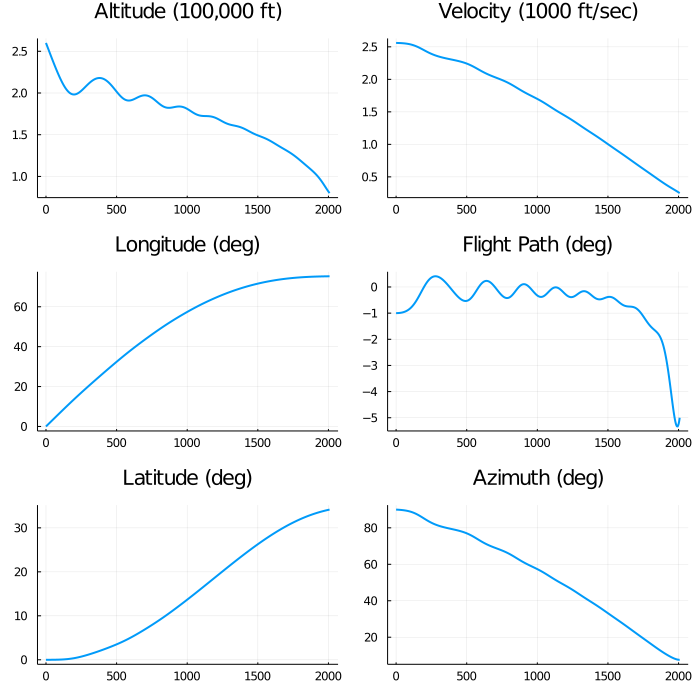

In [4]:
ts = cumsum([0; value.(Œît)])[1:end-1]

plt_altitude = plot(ts, value.(scaled_h), legend = nothing, title = "Altitude (100,000 ft)")
plt_longitude = plot(ts, rad2deg.(value.(œï)), legend = nothing, title = "Longitude (deg)")
plt_latitude = plot(ts, rad2deg.(value.(Œ∏)), legend = nothing, title = "Latitude (deg)")
plt_velocity = plot(ts, value.(scaled_v), legend = nothing, title = "Velocity (1000 ft/sec)")
plt_flight_path = plot(ts, rad2deg.(value.(Œ≥)), legend = nothing, title = "Flight Path (deg)")
plt_azimuth = plot(ts, rad2deg.(value.(œà)), legend = nothing, title = "Azimuth (deg)")

plt = plot(plt_altitude,  plt_velocity, plt_longitude, plt_flight_path, plt_latitude,
           plt_azimuth, layout=grid(3, 2), linewidth=2, size=(700, 700))

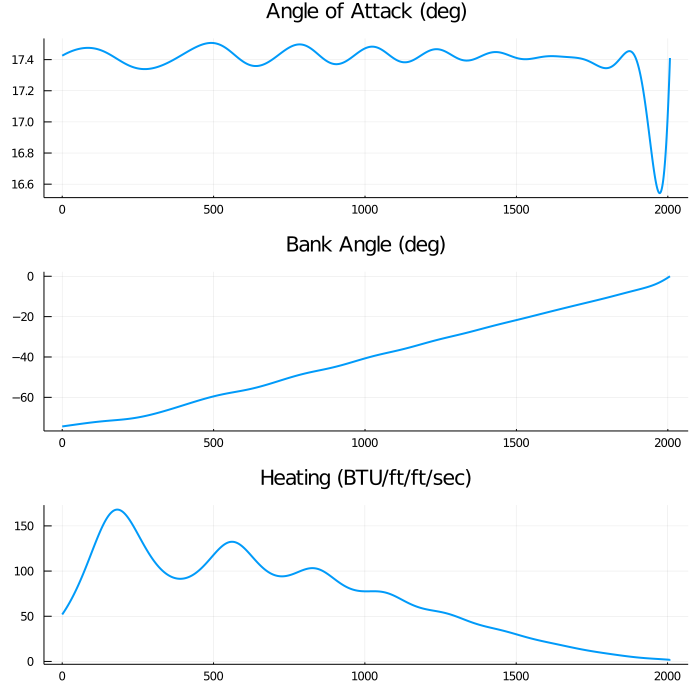

In [5]:
function q(h, v, a)
    œÅ(h) = œÅ‚ÇÄ * exp(-h / h·µ£)
    q·µ£(h, v) = 17700 * ‚àöœÅ(h) * (0.0001 * v)^3.07
    q‚Çê(a) = c‚ÇÄ + c‚ÇÅ * rad2deg(a) + c‚ÇÇ * rad2deg(a)^2 + c‚ÇÉ * rad2deg(a)^3    
    # Aerodynamic heating on the vehicle wing leading edge
    q‚Çê(a) * q·µ£(h, v)
end

plt_attack_angle = plot(ts[1:end-1], rad2deg.(value.(Œ±)[1:end-1]), legend=nothing, title="Angle of Attack (deg)")
plt_bank_angle = plot(ts[1:end-1], rad2deg.(value.(Œ≤)[1:end-1]), legend=nothing, title="Bank Angle (deg)")
plt_heating = plot(ts, q.(value.(scaled_h)*1e5, value.(scaled_v)*1e4, value.(Œ±)), legend=nothing, title="Heating (BTU/ft/ft/sec)") 

plt = plot(plt_attack_angle, plt_bank_angle, plt_heating, layout=grid(3, 1), linewidth=2, size=(700, 700))

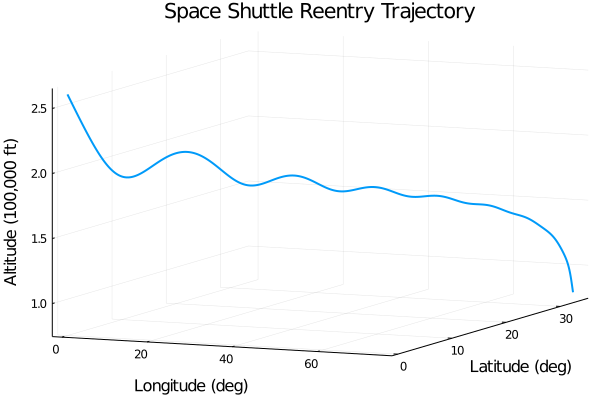

In [6]:
plt = plot(rad2deg.(value.(œï)), rad2deg.(value.(Œ∏)), value.(scaled_h),
           linewidth=2, legend=nothing, title="Space Shuttle Reentry Trajectory",
           xlabel="Longitude (deg)", ylabel="Latitude (deg)", zlabel="Altitude (100,000 ft)")